In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", lambda x: f"{x:.5f}")
plt.style.use("ggplot")
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
sns.set_style("whitegrid")

# 读入数据  
合并表格

In [2]:
q1 = "/Users/chen/Desktop/LendingClub/LoanStats_2017Q1.csv"
q2 = "/Users/chen/Desktop/LendingClub/LoanStats_2017Q2.csv"
q3 = "/Users/chen/Desktop/LendingClub/LoanStats_2017Q3.csv"

# 指定id列为object类型
df1 = pd.read_csv(q1, encoding="latin-1", skiprows=0, header=1, dtype={"id": object, "sec_app_earliest_cr_line": object})
df2 = pd.read_csv(q2, encoding="latin-1", skiprows=0, header=1, dtype={"id": object})
df3 = pd.read_csv(q3, encoding="latin-1", skiprows=0, header=1, dtype={"id": object})

In [3]:
df1.shape

(96781, 144)

In [4]:
df2.shape

(105453, 144)

In [5]:
df3.shape

(122703, 144)

In [6]:
data = pd.concat([df1, df2, df3])

In [7]:
data.shape

(324937, 144)

# 数据预处理

## 去除无关变量  
- 贷后变量  
- 无关变量

In [8]:
post_loan_features = list(data.columns[data.columns.str.contains("pymnt|prncp", regex=True)])
post_loan_features.extend([
    "initial_list_status", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_credit_pull_d"
])

nonsense_features = ["grade", "sub_grade", "zip_code", "addr_state", "title", "policy_code", "earliest_cr_line"]
irrelevant_features = post_loan_features + nonsense_features
irrelevant_features

data.drop(columns=irrelevant_features, inplace=True)
data.shape

(324937, 122)

## 缺失值处理  
### 去除目标变量缺失的样本

In [9]:
data.dropna(subset=["loan_status"], inplace=True)
data.shape

(324931, 122)

### 去除缺失率过大的变量

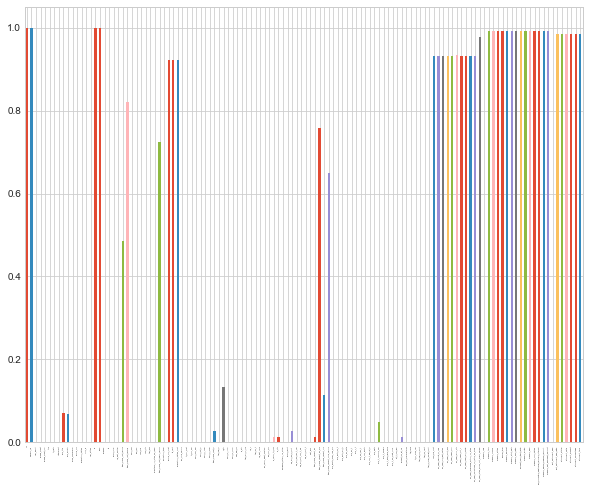

In [10]:
missing_rate = data.isnull().sum() / len(data)
plt.figure(figsize=(10, 8))
missing_rate.plot(kind="bar")
plt.xticks(fontsize=2)
plt.show()

以0.9缺失率为阈值

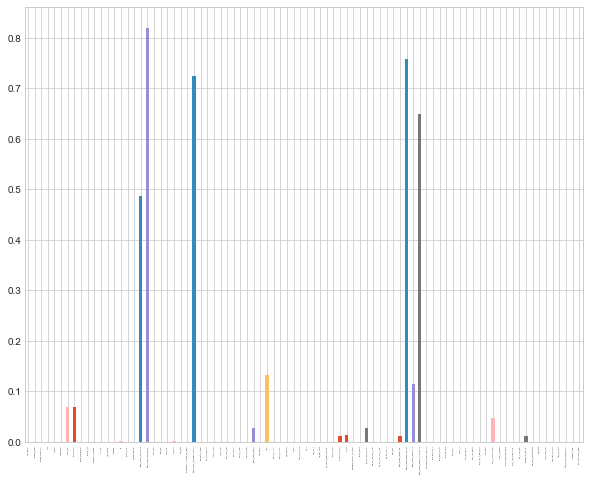

In [11]:
no_na_num = len(data) * 0.1
data.dropna(thresh=no_na_num, axis=1, inplace=True)

missing_rate = data.isnull().sum() / len(data)
plt.figure(figsize=(10, 8))
missing_rate.plot(kind="bar")
plt.xticks(fontsize=2)
plt.show()

In [12]:
(data.isnull().sum() / len(data)).sort_values(ascending=False)[:10]

mths_since_last_record           0.82068
mths_since_recent_bc_dlq         0.75889
mths_since_last_major_derog      0.72457
mths_since_recent_revol_delinq   0.64980
mths_since_last_delinq           0.48588
il_util                          0.13291
mths_since_recent_inq            0.11434
emp_title                        0.06917
emp_length                       0.06817
num_tl_120dpd_2m                 0.04745
dtype: float64

剩余数据中只有7个变量缺失率大于0.1

### 分类变量缺失  
先查看分类变量的情况，确保变量真的是分类变量，而不是数值型变量

In [13]:
data.select_dtypes("object").describe().T

,count,unique,top,freq
term,324931,2,36 months,237742
int_rate,324931,65,16.02%,14697
emp_title,302456,95032,Teacher,6287
emp_length,302782,11,10+ years,107972
home_ownership,324931,5,MORTGAGE,160063
verification_status,324931,3,Source Verified,128887
issue_d,324931,9,Aug-2017,43573
loan_status,324931,7,Current,168542
purpose,324931,13,debt_consolidation,182631
revol_util,324678,1140,0%,1552


注意到：  
- 有些变量应该是数值型，在df中却是object类型，  
  如term、int_rate、emp_length、revol_util主要原因是他们带有单位，需要做格式转换；  
  ??? term需要转换为数值型吗，虽然它的取值是数字，但只有36和60，是否应该保持其为类别变量；  
- emp_title描述的是借款人职业，类型太多，类似于邮编和地址，可以删除；  
- hardship_flag和debt_settlement_flag中某一类型占比非常大，是否可以删除？

In [14]:
data["int_rate"] = data["int_rate"].str.strip("%").astype("float64")
data["revol_util"] = data["revol_util"].str.strip("%").astype("float64")

encoding_emp_length = {
    "10+ years": 10,
    "9 years": 9,
    "8 years": 8,
    "7 years": 7,
    "6 years": 6,
    "5 years": 5,
    "4 years": 4,
    "3 years": 3,
    "2 years": 2,
    "1 year": 1,
    "< 1 year": 0,
}

data.replace(to_replace={"emp_length": encoding_emp_length}, inplace=True)
data.drop(columns=["emp_title"], inplace=True)

In [15]:
data.select_dtypes("object").describe().T

,count,unique,top,freq
term,324931,2,36 months,237742
home_ownership,324931,5,MORTGAGE,160063
verification_status,324931,3,Source Verified,128887
issue_d,324931,9,Aug-2017,43573
loan_status,324931,7,Current,168542
purpose,324931,13,debt_consolidation,182631
application_type,324931,2,Individual,299717
hardship_flag,324931,2,N,324739
debt_settlement_flag,324931,2,N,320009


In [16]:
data.select_dtypes("object").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324931 entries, 0 to 122700
Data columns (total 9 columns):
term                    324931 non-null object
home_ownership          324931 non-null object
verification_status     324931 non-null object
issue_d                 324931 non-null object
loan_status             324931 non-null object
purpose                 324931 non-null object
application_type        324931 non-null object
hardship_flag           324931 non-null object
debt_settlement_flag    324931 non-null object
dtypes: object(9)
memory usage: 24.8+ MB


分类变量已经没有缺失了

### 数值型变量缺失  
在这里简单地用均值填充  
对缺失率>0.1的用均值填充，<0.1的之间删掉

In [17]:
# fill_values = {feature: data[feature].mean() for feature in data.select_dtypes(np.number).columns}

high_miss_f = data.columns[(data.isnull().sum() / len(data)) > 0.1]
fill_values = {feature: data[feature].mean() for feature in high_miss_f}
data.fillna(value=fill_values, inplace=True)

In [18]:
data.dropna(inplace=True)
data.shape

(277912, 83)

In [19]:
# data.isna().info()

数值型变量也没有缺失了

# 定义好坏样本以及目标变量编码  
在暖通的文章中他还定义了一个“中间状态”，包括逾期16-30天、宽恕期内和Default  
在后期使用逻辑回归建模时，只使用好坏两种类型的数据
**创建一个copy数据**

In [20]:
df = data.copy()

encoding_loan_status = {
    "Current": 0,
    "Fully Paid": 0,
    "Late (16-30 days)": 2,
    "Late (31-120 days)": 1,
    "In Grace Period": 2,
    "Default": 2,
    "Charged Off": 1,
}

df.replace(to_replace={"loan_status": encoding_loan_status}, inplace=True)

# 数据集划分  
将第一、二季度的数据用于建模，  
三季度数据用于验证  
统计每个月数据的坏样本率

In [21]:
df = df[df["loan_status"]!=2]
df["issue_d"] = pd.to_datetime(df["issue_d"]).apply(lambda x: x.to_period("M"))

In [22]:
df_by_date = df.groupby("issue_d")
(df_by_date["loan_status"].sum() / df_by_date["loan_status"].count()).reset_index()

,issue_d,loan_status
0,2017-01,0.13185
1,2017-02,0.12763
2,2017-03,0.12072
3,2017-04,0.12286
4,2017-05,0.12102
5,2017-06,0.11430
6,2017-07,0.11170
7,2017-08,0.10291
8,2017-09,0.11051


每个月的bad_rate明显比文章中高了不少，可能是因为文章写的比较早了，分析时还未表现出来；  
LC对数据更新后bad_rate稳定在当前的值了。

In [23]:
df_model = data.copy()
df_model.replace(to_replace={"loan_status": encoding_loan_status}, inplace=True)
df_model = df_model[df_model["loan_status"]!=2]

In [24]:
df_model["issue_d"].value_counts()

Aug-2017    36993
Jul-2017    33580
Sep-2017    33039
Jun-2017    32589
May-2017    32161
Mar-2017    31288
Jan-2017    27356
Apr-2017    25183
Feb-2017    23475
Name: issue_d, dtype: int64

In [25]:
months = ["Jan-2017", "Feb-2017", "Mar-2017", "Apr-2017", "May-2017", "Jun-2017"]
df_train = df_model.loc[df_model["issue_d"].isin(months)]
# 取反 ~
df_test = df_model.loc[~df_model["issue_d"].isin(months)]

In [26]:
len(df_train)

172052

In [27]:
len(df_test)

103612

# 保存清洗后的数据

In [114]:
data.to_csv("LC2017Q1_Q3_clean.csv", index=False)